# Clasificador de radiografías
<br>

## Detección de neumonía

In [1]:
#!pip install imblearn

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import CustomObjectScope

import os
from tqdm import tqdm

import cv2
from glob import glob
import sklearn
import skimage
from skimage.transform import resize
from skimage.color import rgb2gray
from PIL import Image

import random
import datetime

# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler

In [3]:
# comprobar conexion a la GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU no encontrada')
print('Encontrada GPU: {}'.format(device_name))

Encontrada GPU: /device:GPU:0


## PROCESAMIENTO Y SEGMENTACION

In [4]:
### METRICAS ###
def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [5]:
### SEGMENTACION ###
class UnsupportedFormat(Exception):
    def __init__(self, input_type):
        self.t = input_type

    def __str__(self):
        return "La conversión del modo '{}' no es compatible, utilice la dirección de imagen (ruta), el modo PIL.Image (pil) o OpenCV (cv2)".format(self.t)


class MatteMatting():
    def __init__(self, original_graph, mask_graph, input_type='path'):
        """
            Convierta la imagen de entrada en un constructor de imagen transparente a través de una máscara
            : param original_graph: dirección de imagen de entrada, formato PIL, formato CV2
            : param mask_graph: la dirección de imagen de la máscara, formato PIL, formato CV2
            : param input_type: tipo de entrada, ruta: dirección de imagen, pil: tipo de pil, tipo de cv2
        """

        if input_type == 'path':
            self.img1 = cv2.imread(original_graph)
            self.img2 = cv2.imread(mask_graph)

            self.img1 = cv2.resize(self.img1, (512,512))
            # self.img2 = cv2.resize(self.img2, (150,150))

        elif input_type == 'pil':
            self.img1 = self.__image_to_opencv(original_graph)
            self.img2 = self.__image_to_opencv(mask_graph)
        elif input_type == 'cv2':
            self.img1 = original_graph
            self.img2 = mask_graph
        else:
            raise UnsupportedFormat(input_type)

    @staticmethod
    def __transparent_back(img):
        """
            : param img: dirección de imagen entrante
            : return: devuelve la imagen transparente después de reemplazar el blanco
        """
        img = img.convert('RGBA')
        L, H = img.size
        color_0 = (255, 255, 255, 255)  # El color a reemplazar
        for h in range(H):
            for l in range(L):
                dot = (l, h)
                color_1 = img.getpixel(dot)
                if color_1 == color_0:
                    color_1 = color_1[:-1] + (0,)
                    img.putpixel(dot, color_1)
        return img

    def save_image(self, path, mask_flip=False):
        """
            Se usa para guardar imágenes transparentes
            : ruta del parámetro: guardar ubicación
            : param mask_flip: Volteo de máscara, voltea el color blanco y negro de la máscara; Volteo verdadero; Falso no usa volteo
        """
        if mask_flip:
            img2 = cv2.bitwise_not(self.img2)  # Flip en blanco y negro
        image = cv2.add(self.img1, img2)
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # OpenCV convertido a formato PIL.Image
        img = self.__transparent_back(image)
        img.save(path)

    @staticmethod
    def __image_to_opencv(image):
        """
            Convertir PIL.Image a formato OpenCV
        """
        img = cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2BGR)
        return img

## FUNCION NUEVA CON SEGMENTACION

In [6]:
from google.colab import drive
drive.mount('/content/drive')

H = 512
W = 512

segm_path = "drive/MyDrive/DeteccionNeumonia/chest_xray_segm/"

np.random.seed(42)
tf.random.set_seed(42)

if not os.path.exists(f"{segm_path}results"):
    os.makedirs(f"{segm_path}results")


# Cargar modelo
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
    model_segm = tf.keras.models.load_model(f"{segm_path}model_segm.h5")

# directorios con las imagenes de entrenamiento y prueba
train_dir = 'drive/MyDrive/DeteccionNeumonia/chest_xray/train/'
test_dir =  'drive/MyDrive/DeteccionNeumonia/chest_xray/test/'

LOAD_FROM_IMAGES = False

def get_data(folder):
    X = []
    y = []

    # etiquetar radiografias (0 y 1)
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2

            # modificar radiografias
            for image_filename in tqdm(os.listdir(folder + folderName)):

                # Nombre de la imagen
                image_name = image_filename.split("/")[-1]

                ori_x = cv2.imread(folder + folderName + '/' + image_filename, cv2.IMREAD_COLOR)
                ori_x = cv2.resize(ori_x, (W, H))
                x = ori_x/255.0
                x = x.astype(np.float32)
                x = np.expand_dims(x, axis=0)

                # Prediccion de la mascara (segmentacion)
                y_pred = model_segm.predict(x)[0] > 0.5
                y_pred = y_pred.astype(np.int32)

                # Guardar la prediccion de la mascara para la segmentacion posterior
                save_image_path = f"{segm_path}results/{image_name}"
                y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

                cat_image = np.concatenate([y_pred*255], axis=1)
                cv2.imwrite(save_image_path, cat_image)

                # Crear la mascara apartir la imagen original
                mm = MatteMatting(folder + folderName + '/' + image_filename, save_image_path)
                mm.save_image(f"{save_image_path}.png", mask_flip=True) # mask_flip se refiere al giro de la máscara, es decir, convertir el blanco en negro y el negro en blanco

                # Abrir imagen segmentada
                img_file = cv2.imread(f"{save_image_path}.png")
                # reescalar
                img_file = skimage.transform.resize(img_file, (150,150,3), mode='constant', anti_aliasing=True)
                # imagen en gris (blanco y negro)
                img_file = rgb2gray(img_file)

                # Convertir la mascara a array de numpy y agregarla a una lista
                img_arr = np.asarray(img_file)
                X.append(img_arr)
                y.append(label)

                # Remover las imagenes creadas
                os.remove(save_image_path)
                os.remove(f"{save_image_path}.png")

    # Convertir toda la lista a un array de numpy
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y


if LOAD_FROM_IMAGES:
    # cargar las imagenes a los arrays
    X_train, y_train = get_data(train_dir)
    X_test, y_test = get_data(test_dir)

    # grabar los arrays en archivos
    np.save('drive/MyDrive/DeteccionNeumonia/chest_xray_segm/xtrain_segm.npy', X_train)
    np.save('drive/MyDrive/DeteccionNeumonia/chest_xray_segm/ytrain_segm.npy', y_train)
    np.save('drive/MyDrive/DeteccionNeumonia/chest_xray_segm/xtest_segm.npy', X_test)
    np.save('drive/MyDrive/DeteccionNeumonia/chest_xray_segm/ytest_segm.npy', y_test)
    
else:
    # cargar los arrays anteriormente grabados
    X_train = np.load('drive/MyDrive/DeteccionNeumonia/chest_xray_segm/xtrain_segm.npy')
    y_train = np.load('drive/MyDrive/DeteccionNeumonia/chest_xray_segm/ytrain_segm.npy')
    X_test = np.load('drive/MyDrive/DeteccionNeumonia/chest_xray_segm/xtest_segm.npy')
    y_test = np.load('drive/MyDrive/DeteccionNeumonia/chest_xray_segm/ytest_segm.npy')


Mounted at /content/drive


## VISUALIZACIONES DE LOS DATASETS

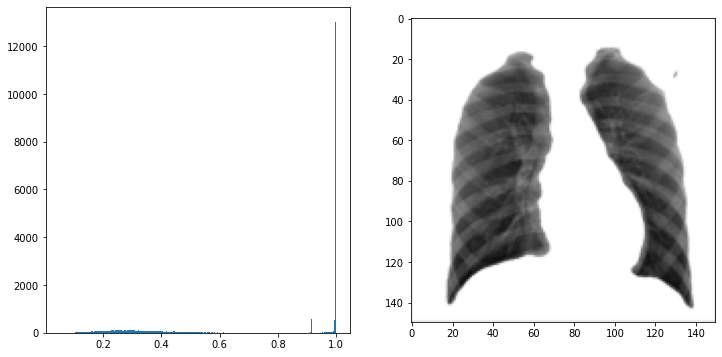

In [7]:
# Histograma para una radiografia
def plotHistogram(a):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.hist(a.ravel(), bins=255)
    plt.subplot(1,2,2)
    plt.imshow(a, cmap='gray', vmin=0, vmax=1)
    plt.show()
    
plotHistogram(X_train[7])

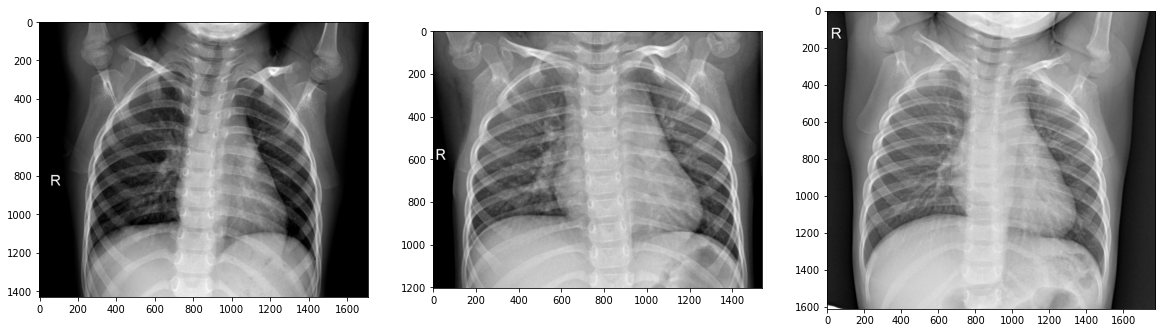

In [8]:
# Mostrar varias imagenes (radiografias)
multipleImages = glob('drive/MyDrive/DeteccionNeumonia/chest_xray/train/NORMAL/**')

def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(20,20))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2]));
    
plotThreeImages(multipleImages)

No Neumonia


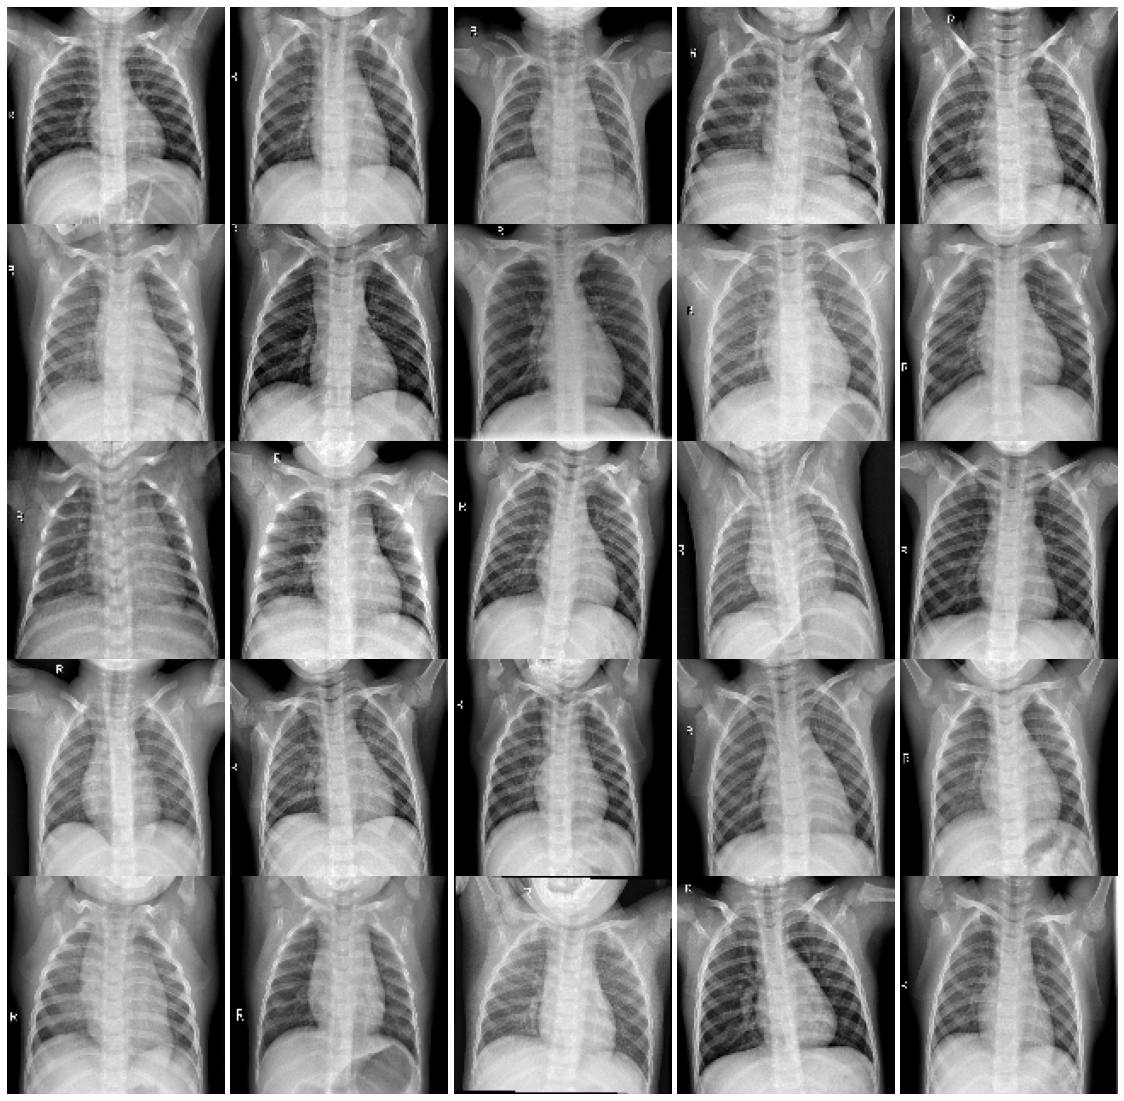

In [9]:
print('No Neumonia')

multipleImages = glob('drive/MyDrive/DeteccionNeumonia/chest_xray/train/NORMAL/**')
i_ = 0

plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.subplots_adjust(wspace=0, hspace=0)

for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128,128))
    plt.subplot(5, 5, i_+1)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

Si Neumonia


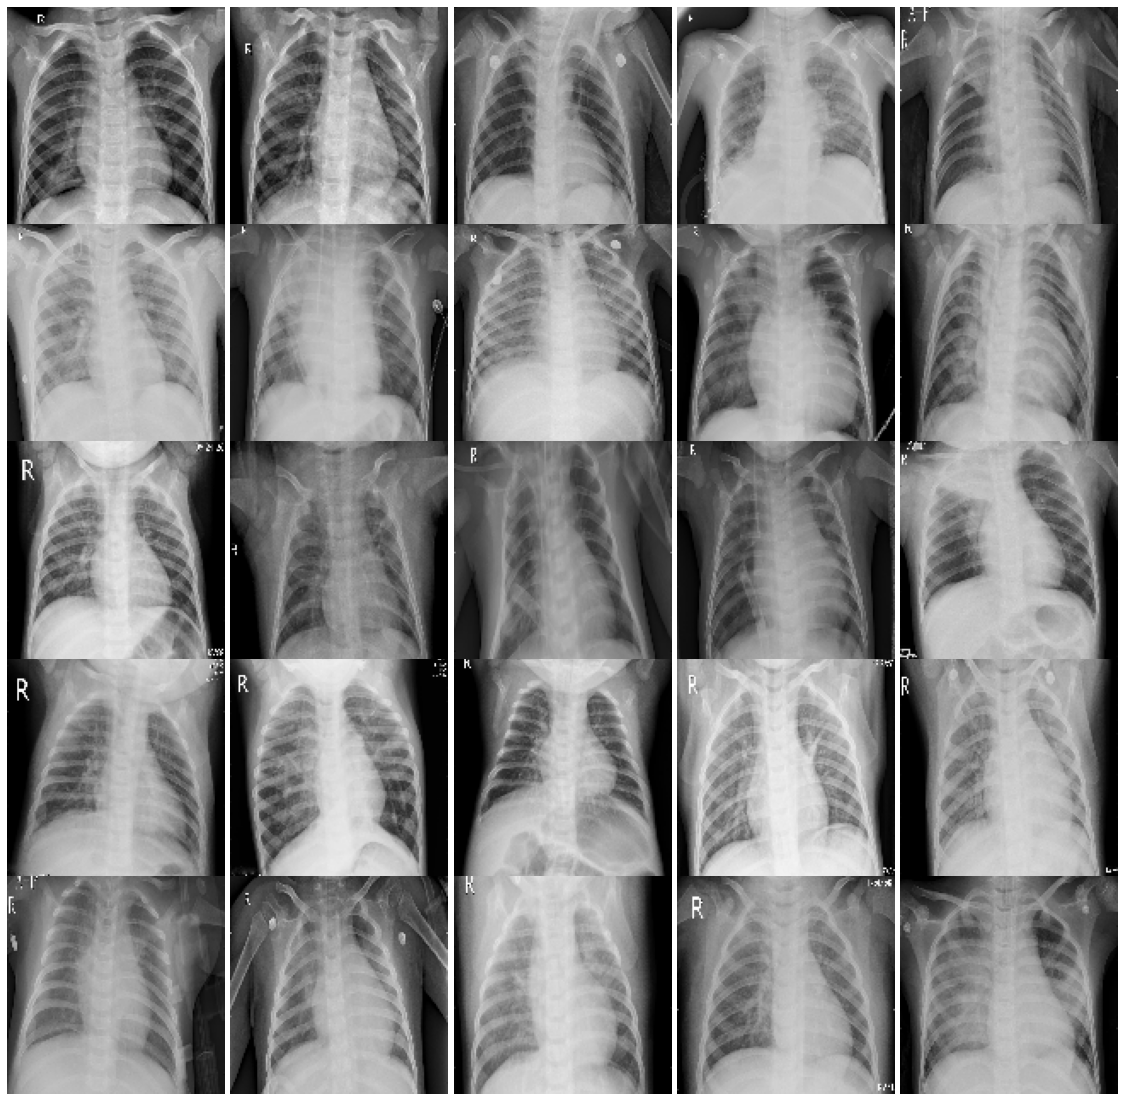

In [10]:
print('Si Neumonia')

multipleImages = glob('drive/MyDrive/DeteccionNeumonia/chest_xray/train/PNEUMONIA/**')
i_ = 0

plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.subplots_adjust(wspace=0, hspace=0)

for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128,128))
    plt.subplot(5, 5, i_+1)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


{0: 'No Neumonia', 1: 'Si Neumonia'}


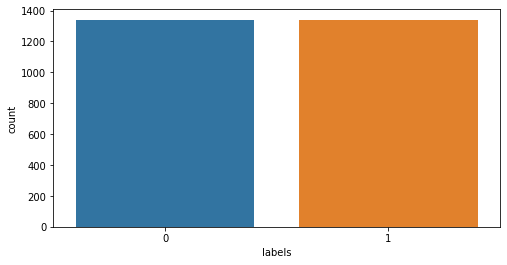

In [11]:
import seaborn as sns

plt.figure(figsize=(8,4))
map_characters = {0: 'No Neumonia', 1: 'Si Neumonia'}
dict_characters = map_characters

df = pd.DataFrame()
df['labels'] = y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

## CONSTRUIR MODELO CNN

In [12]:
"""
X_trainReshaped.shape
y_train
"""
X_train.shape

(2682, 150, 150)

In [13]:
X_trainReshaped = X_train.reshape(len(X_train),150,150,1)
X_testReshaped = X_test.reshape(len(X_test),150,150,1)

X_trainReshaped.shape

(2682, 150, 150, 1)

In [14]:
model = models.Sequential()

model.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [15]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_path = 'drive/MyDrive/DeteccionNeumonia/chest_xray_segm/chekpoints/check'
cp_callbacks = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, 
                                                  save_weights_only=True, verbose=1)

model.fit(X_trainReshaped,
          y_train,
          epochs=20,
          batch_size=4,
          validation_data = (X_testReshaped, y_test),
          callbacks = [cp_callbacks])

Epoch 1/20
671/671 [==============================] - ETA: 0s - loss: 0.3927 - accuracy: 0.8277
Epoch 00001: val_loss improved from inf to 0.51568, saving model to drive/MyDrive/DeteccionNeumonia/chest_xray_segm/chekpoints/check
671/671 [==============================] - 21s 18ms/step - loss: 0.3927 - accuracy: 0.8277 - val_loss: 0.5157 - val_accuracy: 0.7468
Epoch 2/20
670/671 [============================>.] - ETA: 0s - loss: 0.2827 - accuracy: 0.8847
Epoch 00002: val_loss did not improve from 0.51568
671/671 [==============================] - 11s 16ms/step - loss: 0.2825 - accuracy: 0.8848 - val_loss: 0.5237 - val_accuracy: 0.7548
Epoch 3/20
670/671 [============================>.] - ETA: 0s - loss: 0.2433 - accuracy: 0.9007
Epoch 00003: val_loss improved from 0.51568 to 0.48855, saving model to drive/MyDrive/DeteccionNeumonia/chest_xray_segm/chekpoints/check
671/671 [==============================] - 11s 17ms/step - loss: 0.2432 - accuracy: 0.9008 - val_loss: 0.4885 - val_accuracy:

In [16]:
test_loss, test_acc = model.evaluate(X_testReshaped, y_test)
print(test_acc)

20/20 [==============================] - 1s 34ms/step - loss: 2.3441 - accuracy: 0.7933
0.7932692170143127


In [17]:
test_loss, test_acc = model.evaluate(X_trainReshaped, y_train)

84/84 [==============================] - 2s 28ms/step - loss: 4.6671e-05 - accuracy: 1.0000


## Prediccion

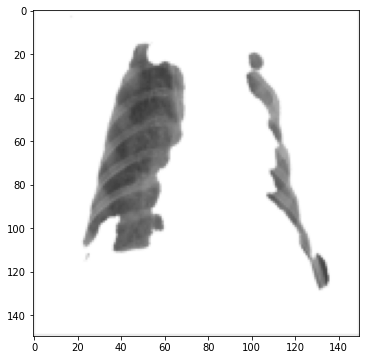

In [23]:
np.random.seed(42)
tf.random.set_seed(42)

# img_path = 'drive/MyDrive/DeteccionNeumonia/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'
img_path = 'drive/MyDrive/DeteccionNeumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'

test_image = cv2.imread(img_path, cv2.IMREAD_COLOR)
test_image_x = cv2.resize(test_image, (512, 512))
x = test_image_x/255.0
x = x.astype(np.float32)
x = np.expand_dims(x, axis=0)


# Prediccion de la mascara (segmentacion)
y_pred = model_segm.predict(x)[0] > 0.5
y_pred = y_pred.astype(np.int32)

# Guardar la prediccion de la mascara para la segmentacion posterior
save_image_path = f"{segm_path}img_pred.jpeg"
y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

cat_image = np.concatenate([y_pred*255], axis=1)
cv2.imwrite(save_image_path, cat_image)


# Crear la mascara apartir la imagen original
mm = MatteMatting(img_path, save_image_path)
mm.save_image(f"{save_image_path}.png", mask_flip=True) # mask_flip se refiere al giro de la máscara, es decir, convertir el blanco en negro y el negro en blanco

# Abrir imagen segmentada
np_test_image = cv2.imread(f"{save_image_path}.png")
# reescalar
np_test_image = skimage.transform.resize(np_test_image, (150,150,3), mode='constant', anti_aliasing=True)
# imagen en gris (blanco y negro)
np_test_image = rgb2gray(np_test_image)

# Convertir la mascara a array de numpy y agregarla a una lista
np_test_image = np.asarray(np_test_image)

os.remove(save_image_path)
os.remove(f"{save_image_path}.png")


plt.figure(figsize=(12,6))
plt.imshow(np_test_image, cmap='gray', vmin=0, vmax=1)
plt.show()

In [24]:
np_test_image = np_test_image.reshape(1,150,150,1)
np_test_image.shape

(1, 150, 150, 1)

In [25]:
resultado = model.predict(np_test_image)
resultado[0]

array([2.7449997e-04, 9.9972552e-01], dtype=float32)

Neumonia


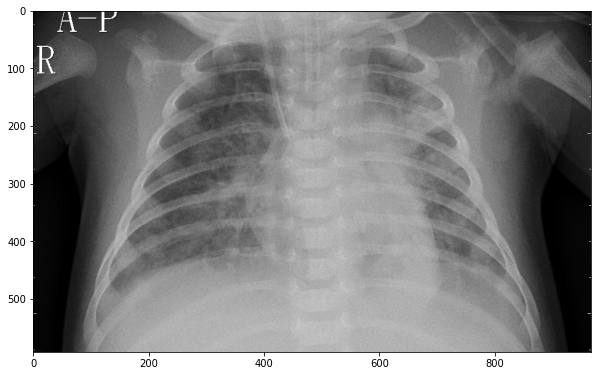

In [26]:
prediccion = np.argmax(resultado[0])

if prediccion == 0:
    print('Normal')
    plt.figure(figsize=(10,10))
    plt.imshow(test_image)
    plt.show()
else:
    print('Neumonia')
    plt.figure(figsize=(10,10))
    plt.imshow(test_image)
    plt.show()

## Entrenamiento usando los pesos guardados

In [27]:
model2 = models.Sequential()

model2.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,1)))
model2.add(layers.MaxPooling2D((2,2)))

model2.add(layers.Conv2D(64, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))

model2.add(layers.Conv2D(64, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))

model2.add(layers.Conv2D(64, (3,3), activation='relu'))


model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(2, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [28]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
# precision antes de cargar los pesos 
loss, acc = model2.evaluate(X_testReshaped, y_test)
print(acc)

20/20 [==============================] - 1s 26ms/step - loss: 0.7421 - accuracy: 0.3750
0.375


In [30]:
# os.chdir(r'drive/MyDrive/DeteccionNeumonia')
# os.getcwd()

In [31]:
# Cargar los pesos desde el archivo guardado

checkpoint_path = 'drive/MyDrive/DeteccionNeumonia/chest_xray_segm/chekpoints/check'
model2.load_weights(checkpoint_path)
model2.save('drive/MyDrive/DeteccionNeumonia/chest_xray_segm/rnc_model_segm.h5') # Guardar el modelo completo
loss, acc = model2.evaluate(X_testReshaped, y_test)
print(acc)

20/20 [==============================] - 1s 27ms/step - loss: 0.4885 - accuracy: 0.7965
0.7964743375778198


### Cargar modelo completo guardado (.h5)

In [32]:
# Hacer predicciones con el modelo completo guardado
from tensorflow.keras.models import load_model
model2 = load_model('drive/MyDrive/DeteccionNeumonia/chest_xray_segm/rnc_model_segm.h5')

In [33]:
model2.summary()
loss, acc = model2.evaluate(X_testReshaped, y_test)
print(acc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

### Hacer predicciones

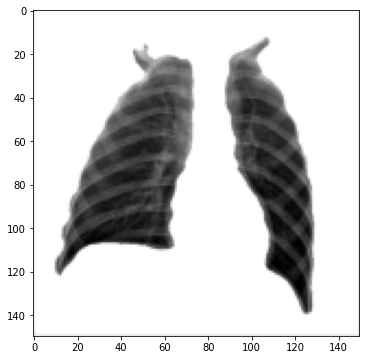

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

img_path = 'drive/MyDrive/DeteccionNeumonia/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg'
# img_path = 'drive/MyDrive/DeteccionNeumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg'

test_image = cv2.imread(img_path, cv2.IMREAD_COLOR)
test_image_x = cv2.resize(test_image, (512, 512))
x = test_image_x/255.0
x = x.astype(np.float32)
x = np.expand_dims(x, axis=0)

# Prediccion de la mascara (segmentacion)
y_pred = model_segm.predict(x)[0] > 0.5
y_pred = y_pred.astype(np.int32)

# Guardar la prediccion de la mascara para la segmentacion posterior
save_image_path = f"{segm_path}img_pred.jpeg"
y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

cat_image = np.concatenate([y_pred*255], axis=1)
cv2.imwrite(save_image_path, cat_image)

# Crear la mascara apartir la imagen original
mm = MatteMatting(img_path, save_image_path)
mm.save_image(f"{save_image_path}.png", mask_flip=True) # mask_flip se refiere al giro de la máscara, es decir, convertir el blanco en negro y el negro en blanco

# Abrir imagen segmentada
np_test_image = cv2.imread(f"{save_image_path}.png")
# reescalar
np_test_image = skimage.transform.resize(np_test_image, (150,150,3), mode='constant', anti_aliasing=True)
# imagen en gris (blanco y negro)
np_test_image = rgb2gray(np_test_image)

# Convertir la mascara a array de numpy y agregarla a una lista
np_test_image = np.asarray(np_test_image)

os.remove(save_image_path)
os.remove(f"{save_image_path}.png")


plt.figure(figsize=(12,6))
plt.imshow(np_test_image, cmap='gray', vmin=0, vmax=1)
plt.show()

In [39]:
np_test_image = np_test_image.reshape(1,150,150,1)
np_test_image.shape

(1, 150, 150, 1)

In [40]:
resultado = model2.predict(np_test_image)
resultado[0]

array([0.9886867 , 0.01131337], dtype=float32)

Normal


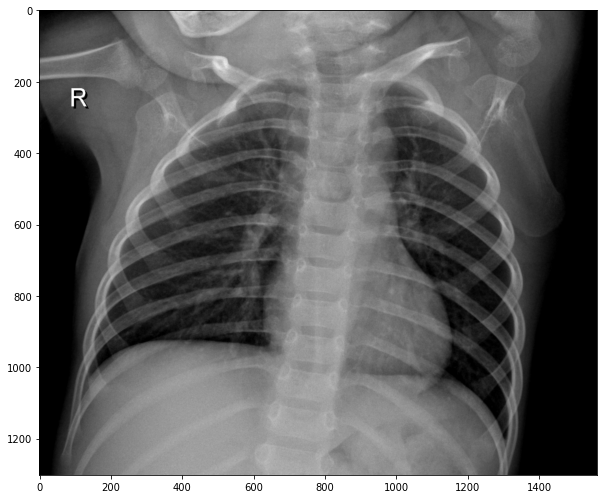

In [41]:
prediccion = np.argmax(resultado[0])

if prediccion == 0:
    print('Normal')
    plt.figure(figsize=(10,10))
    plt.imshow(test_image)
    plt.show()
else:
    print('Neumonia')
    plt.figure(figsize=(10,10))
    plt.imshow(test_image)
    plt.show()
